## Import required modules

In [1]:
# Standard import
import os
import numpy as np
import plotly.graph_objects as go
from numba import njit
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Move to root directory for easier module import
os.chdir("../../")

# Homemade modules
from modules.maldi_data import MaldiData
from modules.figures import Figures
from modules.atlas import Atlas
from modules.tools.volume import fill_array_borders, fill_array_interpolation
from modules.tools.misc import return_pickled_object


# Objects containing our data as well as the atlas data
data = MaldiData()
atlas = Atlas(data, resolution=25)
figures = Figures(data, atlas)



allen mouse atlas (res. 25um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


In [2]:
decrease_dimensionality_factor = 8

# get array of annotatiobs, which associate coordinate to id
array_annotation = np.array(atlas.bg_atlas.annotation, dtype = np.int32)

# Subsample array of annotation the same way array_atlas was subsampled
array_annotation = array_annotation[::decrease_dimensionality_factor, ::decrease_dimensionality_factor, ::decrease_dimensionality_factor]

# bug correction for the last slice
array_annotation = np.concatenate((array_annotation, np.zeros((1,array_annotation.shape[1], array_annotation.shape[2]))))

# choose structure
#for i, keys in atlas.dic_label_id.items():
#    print(keys, i)

id_structure =  None #atlas.dic_label_id["Substantia innominata"]
array_atlas_borders = fill_array_borders(array_annotation, differentiate_borders = False, color_near_borders = False, keep_structure_id = id_structure)

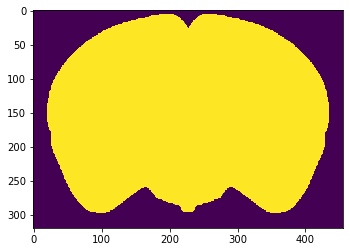

In [3]:
array_to_display = np.array(atlas.bg_atlas.annotation[300,:,:],dtype = np.int32)
plt.imshow(array_to_display , vmin = 0, vmax = 1)
plt.show()

In [4]:
#array_to_display = np.array(array_atlas_borders[30,:,:],dtype = np.float32)
#plt.imshow(array_to_display , vmin = -0.4, vmax = 0)
#plt.show()

size = widgets.IntSlider(value=5, min=0,max=array_atlas_borders.shape[0]-1,step=1, description='Slice')

def hist1(size):
    plt.imshow(array_atlas_borders[size,:,:], vmin = -0.4, vmax = 0)
    return
out = widgets.interactive_output(hist1, {'size':size})

display(size, out)


IntSlider(value=5, description='Slice', max=66)

Output()

In [5]:
from scipy.spatial import Delaunay
import plotly.figure_factory as ff

# Get list of coordinates corresponding to a surface
bool_coor = np.logical_or(array_atlas_borders>=-0.11, array_atlas_borders<=-0.09)
X, Y, Z = np.mgrid[
     0 : array_atlas_borders.shape[0]/1000*25 : array_atlas_borders.shape[0] * 1j,
     0 : array_atlas_borders.shape[1]/1000*25 : array_atlas_borders.shape[1] * 1j,
     0 : array_atlas_borders.shape[2]/1000*25 : array_atlas_borders.shape[2] * 1j,
]

#array_atlas_borders = array_atlas_borders[bool_coor]
X = X[bool_coor]
Y = Y[bool_coor]
Z = Z[bool_coor]
array = np.vstack((X,Y,Z)).T

#pcd = o3d.geometry.PointCloud()
#pcd.points = o3d.utility.Vector3dVector(array)

In [ ]:
# from scipy.spatial import Delaunay
# import plotly.figure_factory as ff

# # Get list of coordinates corresponding to a surface
# bool_coor = np.logical_or(array_atlas_borders>=-0.11, array_atlas_borders<=-0.09)
# X, Y, Z = np.mgrid[
#      0 : array_atlas_borders.shape[0]/1000*25 : array_atlas_borders.shape[0] * 1j,
#      0 : array_atlas_borders.shape[1]/1000*25 : array_atlas_borders.shape[1] * 1j,
#      0 : array_atlas_borders.shape[2]/1000*25 : array_atlas_borders.shape[2] * 1j,
# ]

# #array_atlas_borders = array_atlas_borders[bool_coor]
# X = X[bool_coor]
# Y = Y[bool_coor]
# Z = Z[bool_coor]
# array = np.vstack((X,Y,Z)).T
# print(array.shape)
# tri = Delaunay(array)
# simplices = tri.simplices
# print(simplices)

# fig = ff.create_trisurf(x=X, y=Y, z=Z,simplices=simplices,aspectratio=dict(x=1, y=1, z=0.3))
# fig.show()


In [ ]:
#cloud = pv.PolyData(array)
#volume = cloud.reconstruct_surface()#delaunay_3d()#alpha=0.01)
#shell = volume.extract_geometry()
#test = shell.triangulate()

In [ ]:
# v2 = volume.triangulate()
# print(len(v2.faces)/3)
# print(v2.points)
# print(v2.faces)

In [ ]:
ll_x = []
ll_y = []
ll_z = []
for x in range(2):#array_atlas_borders.shape[0]):
    # from here, I must follow the contour of array_atlas_borders[x,:,:]
    # for simplicity, I can start from bottom left
    y = 0
    z = 0
    # while I found nothing, I keep increasing y first, and z second (the second loop is never started if the first one has exited finding something)
    found = False
    while array_atlas_borders[x,y,z] == -2 and y<array_atlas_borders.shape[1]-1:
        while array_atlas_borders[x,y,z] == -2 and z<array_atlas_borders.shape[2]-1:
            z +=1
        if array_atlas_borders[x,y,z] != -2:
            found = True
            break
        else:
            z = 0
            y +=1

    # If I found a border, I do a nearest neighbour searched from here, taking the outer voxel everytime
    if found:
        l_x = [x]
        l_y = [y]
        l_z = [z]
        n_iter = 0  
        while n_iter<1000:
            n_iter += 1 
            # explore a square, starting with the diagonal points
            up = False
            for yt, zt in [(y-1,z+1), (y+1,z+1),(y+1,z-1), (y-1,z-1), (y,z+1), (y+1,z), (y,z+1),(y-1,z)]:
                # check if still inside brain
                if array_atlas_borders[x,yt,zt] != -2:
                    # check if border (diagonals don't count)
                    for (i,j) in [(-1,0), (0,1), (1,0), (0,-1)]:
                        if array_atlas_borders[x,yt+i,zt+j] == -2:
                            y,z = yt, zt
                            l_x.append(x)
                            l_y.append(y)
                            l_z.append(z)
                            up = True
                            break
                if up:
                    break
            
            if l_x[-1] == l_x[0] and l_y[-1] == l_y[0] and l_z[-1] == l_z[0]:
                break

        ll_x.append(l_x)
        ll_y.append(l_y)
        ll_z.append(l_z)
    
    else:
        # just go to next iteration, since no voxel was found in the current plane
        pass
                        
          
        
array_x = np.array(ll_x)
array_y = np.array(ll_y)
array_z = np.array(ll_z)

print(array_z)
fig = go.Figure(data = go.Surface(x=x, y=y, z=z))
fig.show()        
            
            
            



In [ ]:
a, b, d = 1.32, 1., 0.8
c = a**2 - b**2
u, v = np.mgrid[0:2*np.pi:10j, 0:2*np.pi:10j]
x = (d * (c - a * np.cos(u) * np.cos(v)) + b**2 * np.cos(u)) / (a - c * np.cos(u) * np.cos(v))
y = b * np.sin(u) * (a - d*np.cos(v)) / (a - c * np.cos(u) * np.cos(v))
z = b * np.sin(v) * (c*np.cos(u) - d) / (a - c * np.cos(u) * np.cos(v))

#print(x)
#print(y)
print(z)
fig = go.Figure(data = go.Surface(x=x, y=y, z=z, colorbar_x=-0.07))
fig.show()

In [ ]:
# # Get list of coordinates corresponding to a surface
# bool_coor = np.logical_or(array_atlas_borders==-0.1, array_atlas_borders==-0.2)
# X, Y, Z = np.mgrid[
#      0 : array_atlas_borders.shape[0]/1000*25 : array_atlas_borders.shape[0] * 1j,
#      0 : array_atlas_borders.shape[1]/1000*25 : array_atlas_borders.shape[1] * 1j,
#      0 : array_atlas_borders.shape[2]/1000*25 : array_atlas_borders.shape[2] * 1j,
# ]
# array_atlas_borders = array_atlas_borders[bool_coor]
# X = X[bool_coor]
# Y = Y[bool_coor]
# Z = Z[bool_coor]

#fig = go.Figure(data=[go.Mesh3d(x=X, y=Y, z=Z, alphahull=1,color='lightpink', opacity=0.50)])
#fig.show()

# from scipy.spatial import Delaunay
# import plotly.figure_factory as ff

# points2D = np.vstack([X,Y]).T
# tri = Delaunay(points2D)
# simplices = tri.simplices

# fig = ff.create_trisurf(x=X, y=Y, z=Z,
#                          simplices=simplices)
# fig.show()

In [ ]:
X, Y, Z = np.mgrid[
      0 : array_atlas_borders.shape[0]/1000*25 : array_atlas_borders.shape[0] * 1j,
      0 : array_atlas_borders.shape[1]/1000*25 : array_atlas_borders.shape[1] * 1j,
      0 : array_atlas_borders.shape[2]/1000*25 : array_atlas_borders.shape[2] * 1j,
]


plot_fig = True
if plot_fig:
    fig = go.Figure(
        data=go.Isosurface(
            x=X.flatten(),#[[1,2,3], [1,2,3], [1,2,3]],
            y=Y.flatten(),#[[1,2,3], [1,2,3], [1,2,3]],
            z=Z.flatten(),#[[1,1,1], [2,2,2], [3,3,3]],
            value=array_atlas_borders.flatten(),
            isomin=-0.21,
            isomax=2.55,
            opacity=0.1,  # max opacity
            #opacityscale=[[-0.0, 0], [1., 1]],
            #opacityscale = "uniform",
            surface_count=2,
            #colorscale='Bluyl'#colorscale,
            flatshading = True,
        )
    )

    fig.update_layout(
        margin=dict(t=0, r=0, b=0, l=0),
        scene=dict(
            xaxis=dict(backgroundcolor="rgba(0,0,0,0)", color="grey", gridcolor="grey"),
            yaxis=dict(backgroundcolor="rgba(0,0,0,0)", color="grey", gridcolor="grey"),
            zaxis=dict(backgroundcolor="rgba(0,0,0,0)", color="grey", gridcolor="grey"),
        ),
    )
    fig.show()

In [ ]:
ll_t_bounds = [
    [None, None, None],
    [[(759.6073, 759.6117)], None, None],
    [[(759.6071000000001, 759.6112)], None, None],
    [[(759.6068, 759.6106000000001)], None, None],
    [[(759.6069, 759.6111000000001)], None, None],
    [[(759.6064, 759.6108)], None, None],
    [[(759.6066000000001, 759.611)], None, None],
    [[(759.6067, 759.611)], None, None],
    [[(759.6066000000001, 759.611)], None, None],
    [[(759.6067, 759.6111000000001)], None, None],
    [[(759.6067, 759.6115000000001)], None, None],
    [[(759.6067, 759.611)], None, None],
    [[(759.6066000000001, 759.6111000000001)], None, None],
    [[(759.6067, 759.6112)], None, None],
    [[(759.6069, 759.6111000000001)], None, None],
    [[(759.6070000000001, 759.6111000000001)], None, None],
    [[(759.6069, 759.6112)], None, None],
    [[(759.6069, 759.611)], None, None],
    [[(759.6064, 759.611)], None, None],
    [[(759.6066117365762, 759.6111773745573)], None, None],
    [[(759.6067594505706, 759.6111700259931)], None, None],
    [[(759.6064842656122, 759.6111548755334)], None, None],
    [[(759.6074, 759.6112)], None, None],
    [[(759.6067, 759.6109)], None, None],
    [[(759.6067, 759.611)], None, None],
    [[(759.6067, 759.611)], None, None],
    [[(759.6067, 759.6115000000001)], None, None],
    [[(759.6068, 759.6114)], None, None],
    [[(759.6073, 759.6114)], None, None],
    [[(759.6071000000001, 759.6113)], None, None],
    [None, None, None],
    [[(759.6069, 759.6112)], None, None],
]
array_x, array_y, array_z, array_c = figures.compute_array_3D( ll_t_bounds, normalize_independently=True, high_res=False)


In [ ]:
array_slices = np.copy(array_atlas_borders)
array_for_avg = np.full_like(array_atlas_borders,1)
array_x_scaled = array_x * 1000000 / atlas.resolution / decrease_dimensionality_factor
array_y_scaled = array_y * 1000000 / atlas.resolution / decrease_dimensionality_factor
array_z_scaled = array_z * 1000000 / atlas.resolution / decrease_dimensionality_factor

print(np.min(array_x_scaled), np.max(array_x_scaled))
print(np.min(array_y_scaled), np.max(array_y_scaled))
print(np.min(array_z_scaled), np.max(array_z_scaled))
print(np.min(array_c), np.max(array_c))
print(array_slices.shape)
for x, y, z, c in zip(array_x_scaled, array_y_scaled, array_z_scaled, array_c):
    x_scaled = int(round(y))
    y_scaled = int(round(z))
    z_scaled = int(round(x))
    # if inside the brain but not a border
    if array_slices[x_scaled, y_scaled, z_scaled ] > -0.05:
        # if inside the brain and not assigned before
        if abs(array_slices[x_scaled, y_scaled, z_scaled ] - (-0.01)) < 10**-4:
            array_slices[x_scaled, y_scaled, z_scaled ] = c/100
        # inside the brain but already assigned, in which case average
        else:
            array_slices[x_scaled, y_scaled, z_scaled ] += c/100
            array_for_avg[x_scaled, y_scaled, z_scaled ] += 1
            
array_slices = array_slices/array_for_avg

In [ ]:
plot = False
if plot:
    fig = go.Figure(
        data=go.Volume(
            x=X.flatten(),
            y=Y.flatten(),
            z=Z.flatten(),
            value=array_slices.flatten(),
            isomin = -1,
            isomax= 2.55,
            opacity=0.5,  # max opacity
            opacityscale="uniform",
            surface_count=10,
            colorscale="RdBu_r",
        )
    )

    fig.update_layout(
        margin=dict(t=0, r=0, b=0, l=0),
        scene=dict(
            xaxis=dict(backgroundcolor="rgba(0,0,0,0)", color="grey", gridcolor="grey"),
            yaxis=dict(backgroundcolor="rgba(0,0,0,0)", color="grey", gridcolor="grey"),
            zaxis=dict(backgroundcolor="rgba(0,0,0,0)", color="grey", gridcolor="grey"),
        ),
    )
    fig.show()


In [ ]:
x_min, x_max, y_min, y_max, z_min, z_max = None, None, None, None, None, None
# Crop unfilled parts to save space
for x in range(0,array_annotation.shape[0]):
    if id_structure in array_annotation[x,:,:]:
        x_min = x-1
        break
for x in range(array_annotation.shape[0]-1,-1,-1):
    if id_structure in array_annotation[x,:,:]:
        x_max = x+1
        break
for y in range(0,array_annotation.shape[1]):
    if id_structure in array_annotation[:,y,:]:
        y_min = y-1
        break
for y in range(array_annotation.shape[1]-1,-1,-1):
    if id_structure in array_annotation[:,y,:]:
        y_max = y+1
        break
for z in range(0,array_annotation.shape[2]):
    if id_structure in array_annotation[:,:,z]:
        z_min = z-1
        break
for z in range(array_annotation.shape[2]-1,-1,-1):
    if id_structure in array_annotation[:,:,z]:
        z_max = z+1
        break

if x_min is None:
    print("Bug, no voxel value has been assigned")
else:
    array_annotation = array_annotation[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]
    array_slices = array_slices[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]
    X = X[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]
    Y = Y[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]
    Z = Z[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]

In [ ]:
array_interpolated = fill_array_interpolation(array_annotation, array_slices, divider_radius = 1)
print(np.max(array_interpolated))

In [ ]:
size = widgets.IntSlider(value=5, min=0,max=array_interpolated.shape[0]-1,step=1, description='Slice')

def hist1(size):
    plt.imshow(array_interpolated[size,:,:], vmin = -0.1, vmax = 2.55)
    return
out = widgets.interactive_output(hist1, {'size':size})

display(size, out)

In [ ]:
#size = widgets.IntSlider(value=5, min=0,max=array_slices.shape[0]-1,step=1, description='Slice')
#
#def hist1(size):
#    plt.imshow(array_slices[size,:,:], vmin = -0.1, vmax = 2.55)
#    return
#out = widgets.interactive_output(hist1, {'size':size})
#
#display(size, out)

In [ ]:
plot = True
if plot:
    volume_plot = go.Volume(
            x=X.flatten(),
            y=Y.flatten(),
            z=Z.flatten(),
            value=array_interpolated.flatten(),
            isomin = -0.11,
            isomax= 1.5,
            opacity=0.5,  # max opacity
            opacityscale="uniform",
            surface_count=10,
            colorscale='Bluyl',#"RdBu_r",
            flatshading = False,
            #caps= dict(x_show=False, y_show=False, z_show=False), # no caps
            #cmid=-0.1,
            #cmax = 2.,
            #cmin = -1,
        )
    #brain_root = figures.compute_root_data()#return_pickled_object("figures/atlas_page/3D", "root", force_update=False, compute_function=figures.compute_root_data)

    fig = go.Figure(
        data=volume_plot#[volume_plot, brain_root]
    )

    fig.update_layout(
        margin=dict(t=0, r=0, b=0, l=0),
        scene=dict(
            xaxis=dict(backgroundcolor="rgba(0,0,0,0)", color="grey", gridcolor="grey"),
            yaxis=dict(backgroundcolor="rgba(0,0,0,0)", color="grey", gridcolor="grey"),
            zaxis=dict(backgroundcolor="rgba(0,0,0,0)", color="grey", gridcolor="grey"),
        ),
    )
    fig.show()